### A simple deep learning model for stock price prediction using TensorFlow

Actual prediction of stock prices is a really challenging and complex task that requires tremendous efforts, especially at higher frequencies, such as minutes used here.

In [1]:
import os
# path="C:/Users/Aizhong Lei/AnacondaProjects/us_stock/us_stock_data/"
# os.chdir(path)
path = os.getcwd()
path

'C:\\Users\\Aizhong Lei\\AnacondaProjects\\us_stock'

In [2]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

#### 1.  Importing and preparing the data

The dataset contains n = 41266 minutes of data ranging from April to August 2017 on 500 stocks as well as the total S&P 500 index price. Index and stocks are arranged in wide format.

In [3]:
# Import data
stock = 'MS'
fsn=path + '\\us_stock_data\\' + stock + '.csv'
data = pd.read_csv(fsn)

In [320]:
# import fix_yahoo_finance as yf
# stock = 'BAC'
# start = '2005-01-01'
# end = '2018-08-13'
# data = yf.download(stock, start, end)

In [6]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

# download dataframe
cs = pdr.get_data_yahoo("BAC", start="2005-01-01", end="2018-08-13")


[*********************100%***********************]  1 of 1 downloaded


In [4]:
cs = data
cs.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
4696,2018-08-31,49.090000,49.090000,48.570000,48.830002,48.830002,7698400
4697,2018-09-04,48.860001,48.910000,48.180000,48.709999,48.709999,8548700
4698,2018-09-05,48.650002,49.049999,48.509998,48.720001,48.720001,5527500
4699,2018-09-06,48.549999,48.820000,47.680000,47.930000,47.930000,7990500
4700,2018-09-07,48.020000,48.400002,47.880001,48.220001,48.220001,7242000


In [5]:
data = cs.dropna()['Adj Close']#rolling(window=5).mean().dropna()['Adj Close']
data.shape

(4701,)

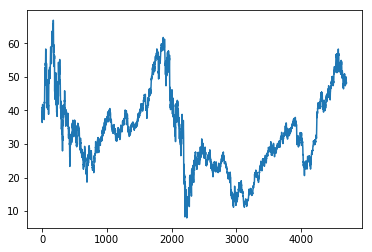

In [6]:
plt.plot(data)

In [7]:
date = cs['Date']#[4:]
len(date)

4701

In [8]:
AC = data[-2000:].values
len(AC)

2000

In [9]:
scaler_X = StandardScaler()
dataset_X = scaler_X.fit_transform(AC.reshape(-1, 1))

In [10]:
def window_data(data,window):
    X = []
    y = []
    idex = 0
    while (idex + window) <= len(data):
        X.append(data[idex:idex+window])
        idex += 1
        
    idex = 0    
    while (idex + window) <= len(data)-1:
        y.append(data[idex+window])
        idex += 1 
    ##  assert len(X)==len(y)
    return X,y

In [11]:
SX , y= window_data(dataset_X,7)
np.shape(SX), np.shape(y)

((1994, 7, 1), (1993, 1))

In [34]:
# def window_data(data, window_size):
#     X = []
#     y = []
    
#     i = 0
#     while (i + window_size) <= len(data) - 1:
#         X.append(data[i:i+window_size])
#         y.append(data[i+window_size])
        
#         i += 1
#     assert len(X) ==  len(y)
#     return X, y

In [12]:
window=7
ll = int(len(SX)/window)*window
X_train  = np.array(SX[:ll])
y_train = np.array(y[:ll])

X_test = np.array(SX[ll:-1])
y_test = np.array(y[ll:])

print("X_train size: {}".format(X_train.shape))
print("y_train size: {}".format(y_train.shape))
print("X_test size: {}".format(X_test.shape))
print("y_test size: {}".format(y_test.shape))


X_train size: (1988, 7, 1)
y_train size: (1988, 1)
X_test size: (5, 7, 1)
y_test size: (5, 1)


### Time to train the network

In [13]:
epochs=200
batch_size = 7

In [14]:
def LSTM_cell(hidden_layer_size, batch_size,number_of_layers, dropout=True, dropout_rate=0.8):
    
    layer = tf.contrib.rnn.BasicLSTMCell(hidden_layer_size)
    
    if dropout:
        layer = tf.contrib.rnn.DropoutWrapper(layer, output_keep_prob=dropout_rate)
        
    cell = tf.contrib.rnn.MultiRNNCell([layer]*number_of_layers)
    
    init_state = cell.zero_state(batch_size, tf.float32)
    
    return cell, init_state

In [15]:
def output_layer(lstm_output, in_size, out_size):
    
    x = lstm_output[:, -1, :]
    print(x)
    weights = tf.Variable(tf.truncated_normal([in_size, out_size], stddev=0.05), name='output_layer_weights')
    bias = tf.Variable(tf.zeros([out_size]), name='output_layer_bias')
    
    output = tf.matmul(x, weights) + bias
    return output

In [16]:
def opt_loss(logits, targets, learning_rate, grad_clip_margin):
    
    losses = []
    for i in range(targets.get_shape()[0]):
        losses.append([(tf.pow(logits[i] - targets[i], 2))])
        
    loss = tf.reduce_sum(losses)/(2*batch_size)
    
    #Cliping the gradient loss
    gradients = tf.gradients(loss, tf.trainable_variables())
    clipper_, _ = tf.clip_by_global_norm(gradients, grad_clip_margin)
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train_optimizer = optimizer.apply_gradients(zip(gradients, tf.trainable_variables()))
    return loss, train_optimizer

In [17]:
class StockPredictionRNN(object):
    
    def __init__(self, learning_rate=0.001, batch_size=7, hidden_layer_size=512, number_of_layers=1, 
                 dropout=True, dropout_rate=0.8, number_of_classes=1, gradient_clip_margin=4, window_size=7):
    
        self.inputs = tf.placeholder(tf.float32, [batch_size, window_size, 1], name='input_data')
        self.targets = tf.placeholder(tf.float32, [batch_size, 1], name='targets')

        cell, init_state = LSTM_cell(hidden_layer_size, batch_size, number_of_layers, dropout, dropout_rate)

        outputs, states = tf.nn.dynamic_rnn(cell, self.inputs, initial_state=init_state)

        self.logits = output_layer(outputs, hidden_layer_size, number_of_classes)

        self.loss, self.opt = opt_loss(self.logits, self.targets, learning_rate, gradient_clip_margin)

In [18]:
tf.reset_default_graph()
model = StockPredictionRNN()

Tensor("strided_slice:0", shape=(7, 512), dtype=float32)


### Time to train the network

In [19]:
session=tf.Session()
session.run(tf.global_variables_initializer())

In [53]:
def train_model():
    for i in range(epochs):
        traind_scores = []
        ii = 0
        epoch_loss = []
        while(ii + batch_size) <= len(X_train):
            X_batch = X_train[ii:ii+batch_size]
            y_batch = y_train[ii:ii+batch_size]

            o, c, _ = session.run([model.logits, model.loss, model.opt], feed_dict={model.inputs:X_batch, model.targets:y_batch})

            epoch_loss.append(c)
            traind_scores.append(o)
            ii += batch_size
        if (i % 20) == 0:
            print('Epoch {}/{}'.format(i, epochs), ' Current loss: {}'.format(np.mean(epoch_loss)))
            
train_model()

Epoch 0/200  Current loss: 0.0016231224872171879
Epoch 20/200  Current loss: 0.0016231610206887126
Epoch 40/200  Current loss: 0.0016129319556057453
Epoch 60/200  Current loss: 0.0016401085304096341
Epoch 80/200  Current loss: 0.0015985332429409027
Epoch 100/200  Current loss: 0.0015079437289386988
Epoch 120/200  Current loss: 0.0015283392276614904
Epoch 140/200  Current loss: 0.0014915819047018886
Epoch 160/200  Current loss: 0.00146591872908175
Epoch 180/200  Current loss: 0.0016001176554709673


In [20]:
import os
path = "C://Users/Aizhong Lei/AnacondaProjects/us_stock/model_logs/"
# checkpoint_dir = os.path.dirname(checkpoint_path)
# checkpoint_dir
model_path = path + stock  + '.ckpt'

In [54]:
saver = tf.train.Saver()
saver.save(session,model_path)

'C://Users/Aizhong Lei/AnacondaProjects/us_stock/model_logs/MS.ckpt'

In [21]:
saver = tf.train.Saver()
saver.restore(sess=session, save_path=model_path)

INFO:tensorflow:Restoring parameters from C://Users/Aizhong Lei/AnacondaProjects/us_stock/model_logs/MS.ckpt


In [57]:
# sup =[]
# for i in range(len(traind_scores)):
#     for j in range(len(traind_scores[i])):
#         sup.append(traind_scores[i][j])

In [55]:
X_test=SX
ll=int(len(X_test)/7)*7
X_test=SX[-ll:]
len(X_test)

1988

In [56]:
tests = []
i = 0
while i+batch_size <= len(X_test):
    
    o = session.run([model.logits], feed_dict={model.inputs:X_test[i:i+batch_size]})
    i += batch_size
    tests.append(o)

In [57]:
tests_new = []
for i in range(len(tests)):
    for j in range(len(tests[i][0])):
        tests_new.append(tests[i][0][j])

In [58]:
# test_results = []
# for i in range(len(X_test)):
# #     if i >= 701:
#         test_results.append(tests_new[i])
# #     else:
# #         test_results.append(None)

In [59]:
t_results = [x for x in tests_new]

In [60]:
dataset_X = scaler_X.inverse_transform(t_results)
len(dataset_X)

1988

In [61]:
# t_results1 = scaler_y.inverse_transform(np.array(t_results))
dataset_X[-1]

array([49.024773], dtype=float32)

In [62]:
yy = scaler_X.inverse_transform(y[-ll:])

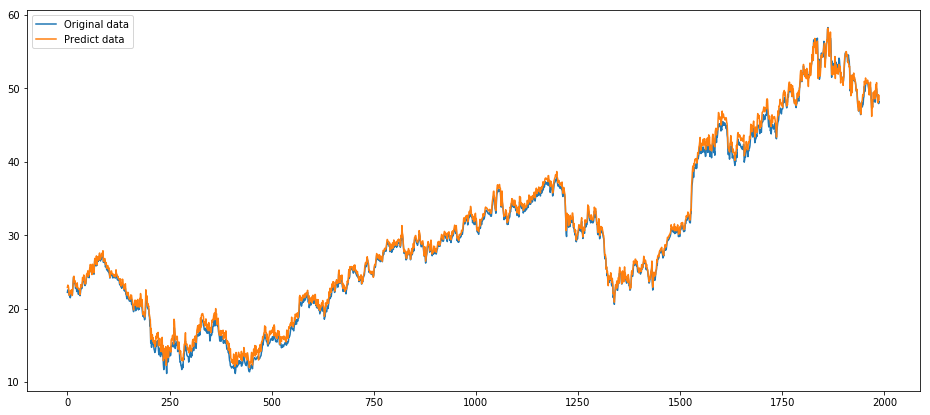

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 7))
# plt.plot(scaled_dataset, label='Original data')
plt.plot(yy, label='Original data')
plt.plot(dataset_X, label='Predict data')
plt.legend()
plt.show()

Predict the future price of stock

In [64]:
X_test=SX[-7:]

np.shape(X_test)

(7, 7, 1)

In [65]:
pre=np.zeros(5)
for i in range(5):
    o = session.run([model.logits], feed_dict={model.inputs:X_test});
    b=o[-1][-1];
    pre[i-1]=b
    a=X_test[-1];
    a = [x for x in a];
    a.append(b);
    a=a[1:];
    X_test.append(a)
    X_test = X_test[1:]

In [66]:
predict = scaler_X.inverse_transform(pre)
len(pre)
predict

array([48.21973831, 48.29279432, 49.02290284, 49.40922988, 47.90520071])

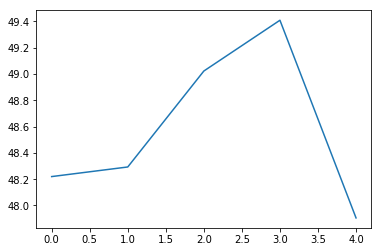

In [67]:
plt.plot(predict)

In [316]:
session.close()

In [49]:
dataset_X[-1]

array([48.598694], dtype=float32)

In [50]:
predict[-7:]

array([48.34158872, 48.76670844, 48.87958965, 48.86277188, 47.92168945])

In [51]:
cs['Adj Close'][-7:]

4694    49.950001
4695    49.299999
4696    48.830002
4697    48.709999
4698    48.720001
4699    47.930000
4700    48.220001
Name: Adj Close, dtype: float64

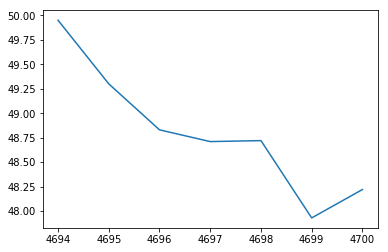

In [52]:
cs['Adj Close'][-7:].plot()